# EX7.네이버 영화리뷰 감성분석 

## 데이터 준비하고 확인

권승민님 깃허브 참고

https://github.com/Kwon-Seung-Min/AIFFEL-Exp-KSM/blob/master/Exp07_final_ksm.ipynb


In [2]:
# 필요한 라이브러리 import
import glob
import os
import re
import numpy as np
import pandas as pd

from collections import Counter

import urllib.request
from konlpy.tag import Okt, Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 훈련 데이터, 테스트 데이터 준비
# ~ 이 HOME
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [4]:
# 훈련 데이터 살펴보기
train_data.head(6)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0


In [5]:
# 테스트 데이터 살펴보기
test_data.head(6)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1


In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
print(len(X_train)) 
print(len(y_train)) 
print('-'*12)
print(len(X_test))
print(len(y_test))
print('-'*36)
print('word_to_index : ',len(word_to_index), type(word_to_index))

146182
146182
------------
49157
49157
------------------------------------
word_to_index :  9997 <class 'dict'>


In [8]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [9]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 모든 문장은 <BOS>로 시작하도록 설정
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode해 주는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공 

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장 길이의 평균값, 최대값, 표준편차 각각 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}% 정도가 maxlen 설정값 이내에 포함되어 있네요! '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575% 정도가 maxlen 설정값 이내에 포함되어 있네요! 


In [13]:
# padding을 통해 문장의 길이를 맞춘다.

x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='post', # 혹은 'pre'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [14]:
# 훈련 데이터 앞쪽 10000개 까지 validation set으로 사용
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 모델 및 validation set 활용

In [15]:
vocab_size = 10000  # 단어 사전의 크기를 지정
word_vector_dim = 4   # 한 단어를 표현하는 임베딩 벡터의 차원의 개수

In [16]:
# 1-D CNN 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [17]:
# 1-D CNN 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=4

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/4
2128/2128 [==============================] - 19s 7ms/step - loss: 0.4880 - accuracy: 0.7475 - val_loss: 0.3445 - val_accuracy: 0.8487
Epoch 2/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3098 - accuracy: 0.8692 - val_loss: 0.3350 - val_accuracy: 0.8525
Epoch 3/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2774 - accuracy: 0.8849 - val_loss: 0.3349 - val_accuracy: 0.8528
Epoch 4/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2570 - accuracy: 0.8951 - val_loss: 0.3412 - val_accuracy: 0.8524


In [18]:
# 1-D CNN 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3519 - accuracy: 0.8495
[0.3518671989440918, 0.8494822978973389]


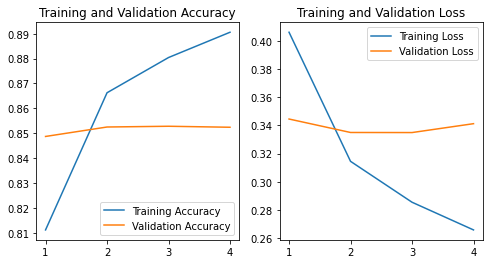

In [19]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# GlobalMaxPooling1D 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [21]:
# GlobalMaxPooling1D 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.6017 - accuracy: 0.6821 - val_loss: 0.4135 - val_accuracy: 0.8255
Epoch 2/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.3927 - accuracy: 0.8364 - val_loss: 0.3825 - val_accuracy: 0.8305
Epoch 3/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.3472 - accuracy: 0.8558 - val_loss: 0.3788 - val_accuracy: 0.8301
Epoch 4/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.3301 - accuracy: 0.8622 - val_loss: 0.3801 - val_accuracy: 0.8335
Epoch 5/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.3109 - accuracy: 0.8693 - val_loss: 0.3815 - val_accuracy: 0.8343


In [22]:
# GlobalMaxPooling1D 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3902 - accuracy: 0.8302
[0.39017969369888306, 0.8301564455032349]


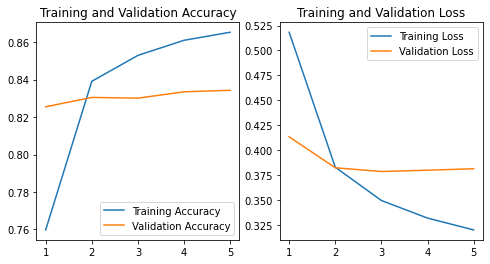

In [23]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# LSTM 레이어 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  #LSTM state 벡터의 차원수
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


In [25]:
# LSTM 레이어 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 20s 8ms/step - loss: 0.5352 - accuracy: 0.6808 - val_loss: 0.3447 - val_accuracy: 0.8484
Epoch 2/5
2128/2128 [==============================] - 18s 8ms/step - loss: 0.3311 - accuracy: 0.8575 - val_loss: 0.3404 - val_accuracy: 0.8529
Epoch 3/5
2128/2128 [==============================] - 16s 8ms/step - loss: 0.3169 - accuracy: 0.8653 - val_loss: 0.3424 - val_accuracy: 0.8513
Epoch 4/5
2128/2128 [==============================] - 16s 8ms/step - loss: 0.3047 - accuracy: 0.8712 - val_loss: 0.3414 - val_accuracy: 0.8553
Epoch 5/5
2128/2128 [==============================] - 16s 8ms/step - loss: 0.2992 - accuracy: 0.8736 - val_loss: 0.3539 - val_accuracy: 0.8496


In [26]:
# LSTM 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3662 - accuracy: 0.8421
[0.3662152886390686, 0.8421180844306946]


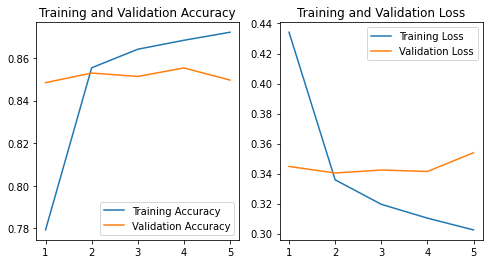

In [27]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

학습된 임베딩 레이어 

In [29]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # 출력 형태 : (vocab_size, embedding_dim)

(10000, 4)


In [31]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 기록

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")

[('아름다운', 0.9993993639945984),
 ('굿', 0.9991140961647034),
 ('넴', 0.9989246726036072),
 ('퍼즐', 0.9987655878067017),
 ('오랫동안', 0.9986292719841003),
 ('실천', 0.9984473586082458),
 ('진실', 0.9982706904411316),
 ('^^~', 0.9981886744499207),
 ('생동감', 0.9981472492218018),
 ('사고', 0.9981369972229004)]

## 한국어 버전 Word2Vec Embedding 활용하기

- Exploration 노드에서는 한국어 버전의 Word2Vec를 활용할 수 있도록 준비되어 있다!
- 이제 한국어로 테스트 해보자!

- 우선 Cloud Shell에 
    pip install --upgrade gensim==3.8.3 
    명령어를 입력해서 다운그레이드를 해주자.
    현재 패키지 버전은 4.0.1

In [46]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'4.0.1'

In [47]:
# 한국어 Word2Vec 파일 불러와 ko_model에 저장하기

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py'>

In [35]:
from gensim.models import KeyedVectors

# 유사한 단어와 그 유사도 확인
ko_model.wv.most_similar("사랑")

NameError: name 'ko_model' is not defined

In [ ]:
ko_model['사랑'].shape

In [ ]:
vocab_size = 10000     # 단어 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim) # 사전학습된 임베딩 레이어의 차원 수 그대로 따라가는 것이 좋아요!

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

# 회고


## 제일 시간을 많이 잡아먹은 부분.


- 경로 설정 부분이었다.

    train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
    
    test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

    위 경로를 입력했는데 경로가 잘못됐다고 오류가 나서 3일 동안 해메다가, 결국은 동료 상현님 깃허브에 있는 주소를 복사해서 넣어봤다.
    코드는 완전 동일한데 실행이 되서 억울했다고나 할까...
    특수문자가 사람 눈에 보이는것과 컴퓨터가 인지하는게 다른가보다.

- '사랑' 이라는 단어에 대한 유사단어/유사도가 아래와 같이 나왔다

    [('아름다운', 0.9993993639945984),
    
     ('굿', 0.9991140961647034),
     
     ('넴', 0.9989246726036072),
     
     ('퍼즐', 0.9987655878067017),
     
     ('오랫동안', 0.9986292719841003),
     
     ('실천', 0.9984473586082458),
     
     ('진실', 0.9982706904411316),
     
     ('^^~', 0.9981886744499207),
     
     ('생동감', 0.9981472492218018),
     
     ('사고', 0.9981369972229004)]
     
    - 위 결과를 보니까 '사랑'이라는 한글 키워드로는 영어로 만들어진 Word2Vec으로는 활용하기 힘들다고 봐야할 것 같다.

- 짜잔! 그래서 한국어 Word2Vec 파일을 사용하기로 했다.

    - word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
    
    
    - import gensim
        gensim.__version__ 버전을 체크해보니 '4.0.1' 이고 3.8.3 버젼으로 다운그레이드를 했지만 적용이 안되서 나중에 다시 해결해 봐야겠다.
        

